In [1]:
import torch
from nerf_shared import config_parser, utils
import numpy as np
import trimesh
parser = config_parser.config_parser()
args = parser.parse_args(args=['--config', 'teddy_bear/config.txt', '--basedir', '.', '--datadir', './nerf_shared/data/nerf_synthetic/teddy_bear'])
torch.set_default_tensor_type(torch.cuda.FloatTensor)
%load_ext autoreload
%autoreload 2

In [4]:
args

Namespace(N_importance=128, N_rand=4096, N_samples=64, basedir='.', chunk=32768, config='teddy_bear/config.txt', datadir='./nerf_shared/data/nerf_synthetic/teddy_bear', dataset_type='blender', expname='teddy_bear', factor=8, ft_path=None, half_res=True, i_embed=0, i_img=500, i_print=100, i_testset=1000, i_video=200000, i_weights=10000, lindisp=False, llffhold=8, lrate=0.0005, lrate_decay=500, multires=10, multires_views=4, netchunk=65536, netdepth=8, netdepth_fine=8, netwidth=256, netwidth_fine=256, no_batching=True, no_ndc=False, no_reload=False, perturb=1.0, precrop_frac=0.5, precrop_iters=500, raw_noise_std=0.0, render_factor=0, render_only=False, render_test=False, shape='greek', spherify=False, tensorboard=False, testskip=1, training=True, use_viewdirs=True, white_bkgd=True)

In [2]:
coarse_model, fine_model = utils.create_nerf_models(args)
optimizer = utils.get_optimizer(coarse_model, fine_model, args)
utils.load_checkpoint(coarse_model, fine_model, optimizer, args)
images, poses, render_poses, hwf, i_split, K, bds_dict = utils.load_datasets(args)
bds_dict = {'near': 0.2, 'far':1.0}
renderer = utils.get_renderer(args, bds_dict)
H, W, focal = hwf

Found ckpts ['./teddy_bear/010000.tar', './teddy_bear/020000.tar', './teddy_bear/030000.tar', './teddy_bear/040000.tar', './teddy_bear/050000.tar', './teddy_bear/060000.tar', './teddy_bear/070000.tar', './teddy_bear/080000.tar', './teddy_bear/090000.tar', './teddy_bear/100000.tar', './teddy_bear/110000.tar', './teddy_bear/120000.tar', './teddy_bear/130000.tar', './teddy_bear/140000.tar', './teddy_bear/150000.tar', './teddy_bear/160000.tar', './teddy_bear/170000.tar', './teddy_bear/180000.tar', './teddy_bear/200000.tar']
Reloading from ./teddy_bear/200000.tar
/media/data/pculbert/Documents/nerf_grasping
Loaded blender (112, 400, 400, 4) torch.Size([40, 4, 4]) [400, 400, 555.5555155968841] ./nerf_shared/data/nerf_synthetic/teddy_bear
Not ndc!
{'training': True, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_pre_hooks': OrderedDict(),

In [3]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
img, disp, _, _ = renderer.render_from_pose(H, W, K, args.chunk, torch.from_numpy(poses[5]).cuda(), coarse_model, fine_model)

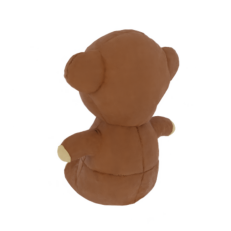

In [22]:
from matplotlib import pyplot as plt
plt.imshow(img.cpu().reshape(H,W,3))
plt.axis('off')
plt.show()

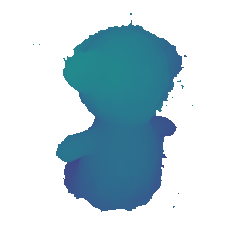

In [17]:
plt.imshow(disp.cpu().reshape(H,W,1))
plt.axis('off')
plt.show()

In [3]:
import mesh_utils
# fig, ax = mesh_utils.get_axis()
verts, faces, normals, values = mesh_utils.marching_cubes(coarse_model, level_set=100., num_points=100)
# mesh_utils.plot_mesh(ax, verts, faces)
# plt.show()
mm = trimesh.Trimesh(verts, faces, normals)
trimesh.repair.fix_inversion(mm)
mm.show()

face_normals incorrect shape, ignoring!


In [4]:
import trimesh
gt_mesh = trimesh.load('nerf_shared/data/nerf_synthetic/teddy_bear/bear_demo.glb', force='mesh')
T = trimesh.transformations.euler_matrix(np.pi/2, 0., 0.,'rxyz')
gt_mesh.apply_transform(T)
mm = trimesh.Trimesh(verts, faces, normals)
trimesh.repair.fix_inversion(mm)
mm.show()
scene = trimesh.Scene()
scene.add_geometry(mm)
scene.add_geometry(gt_mesh)
scene.show()

primitive has no mode! trying GL_TRIANGLES?
primitive has no mode! trying GL_TRIANGLES?
primitive has no mode! trying GL_TRIANGLES?
concatenating texture: may result in visual artifacts
face_normals incorrect shape, ignoring!


In [5]:
from pypoisson import poisson_reconstruction
mm_faces, mm_vertices = poisson_reconstruction(verts, normals, depth=5)
gt_normals = trimesh.geometry.weighted_vertex_normals(
                len(gt_mesh.vertices),
                gt_mesh.faces,
                gt_mesh.face_normals,
                gt_mesh.face_angles)
gt_faces, gt_vertices = poisson_reconstruction(gt_mesh.vertices, gt_normals)
gt_mesh = trimesh.Trimesh(gt_vertices, gt_faces)

In [6]:
intersection = trimesh.boolean.intersection([mm, gt_mesh], engine='blender')
union = trimesh.boolean.union([mm, gt_mesh], engine='blender')

In [72]:
int_normals = trimesh.geometry.weighted_vertex_normals(
                len(intersection.vertices),
                intersection.faces,
                intersection.face_normals,
                intersection.face_angles)

union_normals = trimesh.geometry.weighted_vertex_normals(
                len(union.vertices),
                union.faces,
                union.face_normals,
                union.face_angles)

union_faces, union_verts = poisson_reconstruction(union.vertices, union_normals, depth=5)
int_faces, int_verts = poisson_reconstruction(intersection.vertices, int_normals, depth=5)

union_poisson = trimesh.Trimesh(union_verts, union_faces)
int_poisson = trimesh.Trimesh(int_verts, int_faces)

In [10]:
thresholds = np.linspace(1, 500, num=25)
ious = []

for tt in thresholds:
    verts, faces, normals, values = mesh_utils.marching_cubes(coarse_model, level_set=tt, num_points=100)
    mm = trimesh.Trimesh(verts, faces, vertex_normals=normals)
    ious.append(mesh_utils.iou(gt_mesh, mm))

In [89]:
intersection = trimesh.boolean.intersection([mm, gt_mesh], engine='blender')
union = trimesh.boolean.union([mm,gt_mesh], engine='blender')
int_normals = trimesh.geometry.weighted_vertex_normals(
            len(intersection.vertices),
            intersection.faces,
            intersection.face_normals,
            intersection.face_angles)

union_normals = trimesh.geometry.weighted_vertex_normals(
                len(union.vertices),
                union.faces,
                union.face_normals,
                union.face_angles)

union_faces, union_verts = poisson_reconstruction(union.vertices,
                                                  union_normals, depth=5)
int_faces, int_verts = poisson_reconstruction(intersection.vertices,
                                              int_normals, depth=5)

union_poisson = trimesh.Trimesh(union_verts, union_faces)
int_poisson = trimesh.Trimesh(int_verts, int_faces)

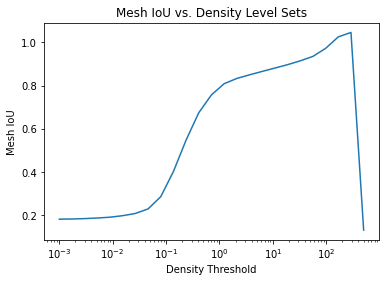

In [125]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.set_xscale('log')
plt.plot(thresholds, ious)
ax.set_title('Mesh IoU vs. Density Level Sets')
ax.set_xlabel('Density Threshold')
ax.set_ylabel('Mesh IoU')
plt.show()

In [115]:
ious

[0.18131309237902812,
 0.18131304870997747,
 0.18131297667952945,
 0.1813129758546382,
 0.1813129450478134,
 0.18131308792233886,
 0.1813131763667248,
 0.18131281383933182,
 0.1813130116005391,
 0.18131290857419402,
 0.18131305573418527,
 0.18131294921285132,
 0.1813129363590645,
 0.1813129093244523,
 0.18131300100074157,
 0.18131304436320694,
 0.18131314172895413,
 0.18131253738299186,
 0.18131299382687863,
 0.18131308268426544,
 0.181312887887192,
 0.18131286740752423,
 0.18131289786098015,
 0.18131322003604888,
 0.18131281637933747]